In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from lmfit import Model

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'

dpi = 150

hue_order = ["VAE", "PCA", "nanoTxformer", "RandomProjection"]
c6 = ['#c4bae2','#40ada6','#3c4ebf',  
        '#e3a600', '#edb1a3', '#d6543a',]
pretty_palette = [c6[c] for c in range(6) if c in [1,2,3,5]]

In [3]:
merf_df = pd.read_csv('../results/MERFISH_scaling.csv', index_col=0)
cite_df = pd.read_csv('../results/PBMC_CITEseq_scaling.csv', index_col=0)
larry_df = pd.read_csv('../results/LARRY_scaling.csv', index_col=0)

In [5]:
def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

def info_max(A, B):
    return 0.5 * np.log2(B/A)

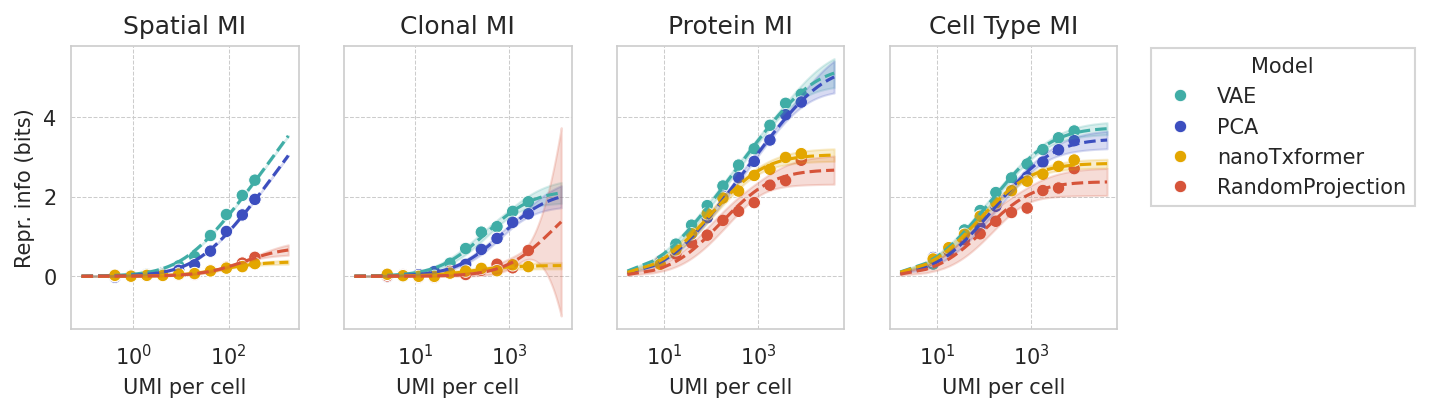

In [6]:
fig = plt.figure(figsize=(9, 2.5), dpi=dpi)

axs = fig.subplots(1, 4, sharey=True)
dfs = [merf_df, larry_df, cite_df, cite_df]
metrics = ['Spatial neighborhood MI', 'Clonal MI', 'Protein MI', 'Cell type fine MI']
names = ['Spatial MI', 'Clonal MI', 'Protein MI', 'Cell Type MI']

for ax, df, metric, name in zip(axs, dfs, metrics, names):
    max_cells = df[df['Cell number'] == df['Cell number'].max()]
    sns.scatterplot(data=max_cells, 
                x='UMI per cell', y=metric,
                hue='Method', marker='o',
                palette=pretty_palette, hue_order=hue_order,
                ax=ax, legend=name==names[-1])

    for i, method in enumerate(hue_order):
        x_data = max_cells[max_cells['Method']== method]['UMI per cell']
        ydata = max_cells[max_cells['Method']== method][metric]


        model = Model(info_scaling)
        params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
        params['A'].min = 0  # set bounds
        params['B'].min = 0

        # fit model
        result = model.fit(ydata, params, x=x_data)

        x_fit = np.linspace(x_data.min()/5, 5*x_data.max(), 10**4)
        y_fit = model.eval(params=result.params, x=x_fit)

        # calculate confidence bands
        # https://www.astro.rug.nl/software/kapteyn/kmpfittutorial.html#confidence-and-prediction-intervals
        
        y_upper = result.eval_uncertainty(params=result.params, 
                                        x=x_fit, sigma=2)
        y_lower = -y_upper

        ax.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, color=pretty_palette[i], alpha=0.2)

        ax.plot(x_fit, y_fit, color=pretty_palette[i], linestyle='--')
    
    ax.set_title(name)
    ax.set_xscale('log')
    ax.set_ylabel('')

axs[0].set_ylabel('Repr. info (bits)')

sns.move_legend(axs[-1], "upper left", bbox_to_anchor=(1.1, 1.03), title='Model')

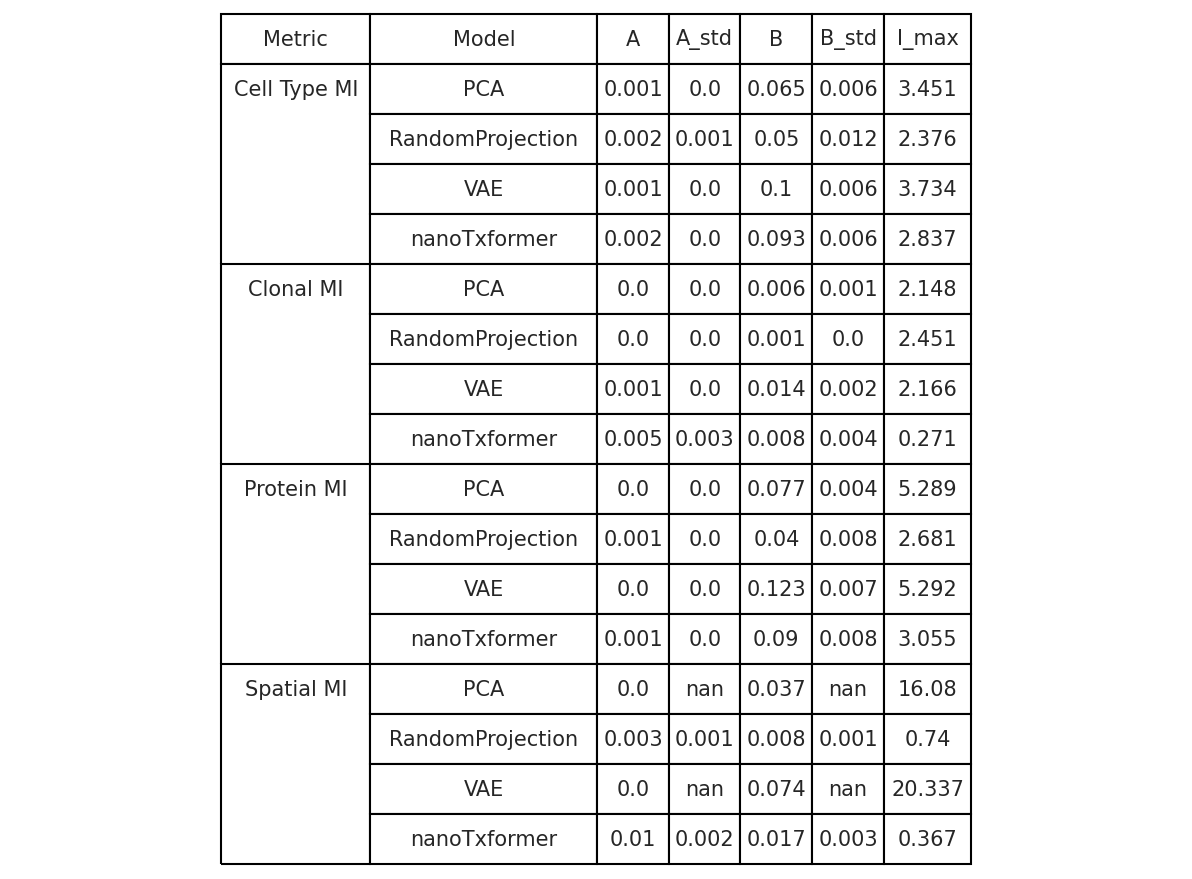

In [31]:
results = []  # to store fit results

# input data
dfs = [merf_df, larry_df, cite_df, cite_df]
metrics = ['Spatial neighborhood MI', 'Clonal MI', 'Protein MI', 'Cell type fine MI']
names = ['Spatial MI', 'Clonal MI', 'Protein MI', 'Cell Type MI']

for df, metric, name in zip(dfs, metrics, names):
    max_cells = df[df['Cell number'] == df['Cell number'].max()]

    for method in hue_order:
        x_data = max_cells[max_cells['Method'] == method]['UMI per cell']
        ydata = max_cells[max_cells['Method'] == method][metric]

        # fit model
        model = Model(info_scaling)
        params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
        params['A'].min = 0
        params['B'].min = 0
        result = model.fit(ydata, params, x=x_data)

        # append results to table
        results.append({
            'Metric': name,
            'Model': method,
            'A': round(result.params['A'].value, 3),
            'B': round(result.params['B'].value, 3),
            'A_std': round(result.params['A'].stderr, 3) if result.params['A'].stderr else None,
            'B_std': round(result.params['B'].stderr, 3) if result.params['B'].stderr else None,
            'I_max' : round(info_max(result.params['A'].value, result.params['B'].value), 3)
        })

# convert results to dataframe
results_df = pd.DataFrame(results)

# sort the dataframe for proper grouping by Metric
results_df = results_df.sort_values(by=['Metric', 'Model'])

# plot the table
fig, ax = plt.subplots(figsize=(10, len(results_df) * 0.4), dpi=dpi)
ax.axis('tight')
ax.axis('off')

# group by metric for merging rows
metrics = results_df['Metric'].unique()
cell_text = []
merge_cells = []
for metric in metrics:
    metric_data = results_df[results_df['Metric'] == metric]
    merge_cells.append((len(cell_text), len(metric_data)))
    cell_text.extend(metric_data[['Model', 'A', 'A_std', 'B', 'B_std', 'I_max']].values.tolist())

# create column headers
columns = ['Metric', 'Model', 'A', 'A_std', 'B', 'B_std', 'I_max']

# add a blank space for merged metric column
cell_text = [["", *row] for row in cell_text]
for start, count in merge_cells:
    cell_text[start][0] = metrics[merge_cells.index((start, count))]

# plot the table
table = ax.table(
    cellText=cell_text,
    colLabels=columns,
    loc='center',
    cellLoc='center'
)

# merge metric cells
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(columns))))
for start, count in merge_cells:
    # table[(start + 1, 0)].set_facecolor(pretty_palette[i])
    table[(start + 1, 0)].visible_edges = 'TRL'
    for i in range(1, count):
        table[(start + 1 + i, 0)].visible_edges = 'RL'
table[(16, 0)].visible_edges = 'BLR'
table.scale(2, 2)
plt.show()
